# Neste notebook é o feito pré processamento dos dados e uma análise exploratória

In [1]:
import pandas as pd
import numpy as np
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
import re, os, random
from nltk.corpus import stopwords
import warnings
from keras.preprocessing.text import text_to_word_sequence
warnings.simplefilter("ignore", UserWarning)
pd.set_option('mode.chained_assignment', None)
seed = 7
np.random.seed(seed)

Using TensorFlow backend.


In [2]:
data = pd.read_csv("dados/train.tsv", sep="\t")

In [3]:
data.head(30)

,Id,IdSentenca,Texto,Sentimento
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2
5,6,1,of escapades demonstrating the adage that what...,2
6,7,1,of,2
7,8,1,escapades demonstrating the adage that what is...,2
8,9,1,escapades,2
9,10,1,demonstrating the adage that what is good for ...,2


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156060 entries, 0 to 156059
Data columns (total 4 columns):
Id            156060 non-null int64
IdSentenca    156060 non-null int64
Texto         156060 non-null object
Sentimento    156060 non-null int64
dtypes: int64(3), object(1)
memory usage: 4.8+ MB


# Descrição dos dados
* <b>Colunas:</b> ID, IdSentenca, Texto, Sentimento
* <b>Linhas:</b> 156060 
* <b> Contexto:</b> São descrições de filmes por usuários
* <b> Idioma:</b> Inglês
* <b> Sentimentos distintos:</b> 5 - negativo, um pouco negativo, neutro, um pouco positivo e positivo

# Metodologia
* <b>Análise das colunas</b> 
* <b>Contagem de palavras</b>
* <b>Classificar o texto de acordo com seu sentimento</b>




# 1.1 Análise das colunas

* A coluna ID foi removida por não fazer diferença na classificação, entretanto, a coluna IdSentenca foi analisada com mais cautela, pois inferi que IdSentenca reprensenta uma mesma descrição do texto, mas analisei de duas formas:
- A primeira foi desconsiderando essa coluna, portanto, a removi
- A segunda foi concatenando os textos que tinham o mesmo IdSentenca, e pegado a moda dos sentimentos deles para cada sentença


# Pré-processamento do Texto desconsiderando a coluna IdSentenca

In [5]:
def clean_str(string):
    string = re.sub(r"\'s", " \'s", string)
    string = re.sub(r"\'ve", " \'ve", string)
    string = re.sub(r"n\'t", " n\'t", string)
    string = re.sub(r"\'re", " \'re", string)
    string = re.sub(r"\'d", " \'d", string)
    string = re.sub(r"\'ll", " \'ll", string)
    string = re.sub(r",", " , ", string)
    string = re.sub(r"!", " ! ", string)
    string = re.sub(r"\(", " \( ", string)
    string = re.sub(r"\)", " \) ", string)
    string = re.sub(r"\?", " \? ", string)
    string = re.sub(r"\s{2,}", " ", string)

    cleanr = re.compile('<.*?>')

    string = re.sub(r'\d+', '', string)
    string = re.sub(cleanr, '', string)
    string = re.sub("'", '', string)
    string = re.sub(r'\W+', ' ', string)
    string = string.replace('_', '')
    
    stop_words = set(stopwords.words('english'))
    word_list = text_to_word_sequence(string)
    no_stop_words = [w for w in word_list if not w in stop_words]
    no_stop_words = " ".join(no_stop_words)
    string = no_stop_words


    return string.strip().lower()

# Aplicando a função de pré-processamento

In [6]:
data['Texto'] = data['Texto'].apply(lambda x: clean_str(x))

In [7]:
data.head(5)

,Id,IdSentenca,Texto,Sentimento
0,1,1,series escapades demonstrating adage good goos...,1
1,2,1,series escapades demonstrating adage good goose,2
2,3,1,series,2
3,4,1,,2
4,5,1,series,2



## Remevendo linhas com espaço vazio


In [8]:
indexs =  data[data['Texto'] == '' ].index
data.drop(indexs , inplace=True)
data.head()

,Id,IdSentenca,Texto,Sentimento
0,1,1,series escapades demonstrating adage good goos...,1
1,2,1,series escapades demonstrating adage good goose,2
2,3,1,series,2
4,5,1,series,2
5,6,1,escapades demonstrating adage good goose,2


### Constatou-se que palavras iguais tem sentimentos diferentes, como é possível ver abaixo:
* O texto <b>good goose</b> aparece com o sentimento 2 e 3


In [9]:
data.iloc[13:16]

,Id,IdSentenca,Texto,Sentimento
17,18,1,good goose,2
19,20,1,good goose,2
21,22,1,good goose,3


# Nuvem de palavras 

In [10]:
def nuvem(data):
    list_words = []
    for label  in np.unique(data["Sentimento"].values):
        text= ""
        for comment, li in zip(data['Texto'], data["Sentimento"]):
                if li == label:
                    text += " "+comment
        print(label)
        wordcloud = WordCloud(max_font_size=50, max_words=200, background_color="black").generate(text)
        plt.figure()
        plt.imshow(wordcloud,interpolation="bilinear")
        plt.axis("off")
        plt.show()
        list_words.append(wordcloud.words_)
        
    return list_words

0


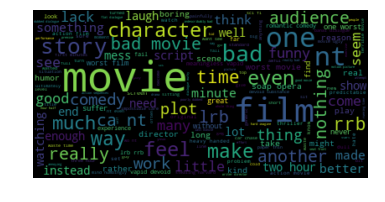

1


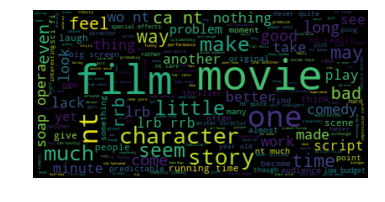

2


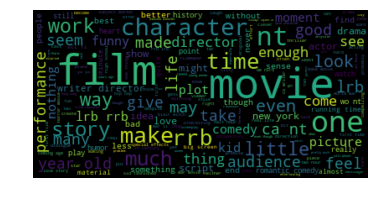

3


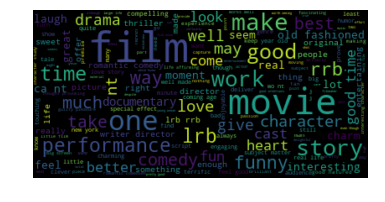

4


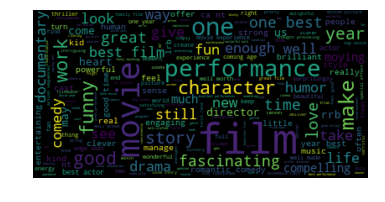

In [11]:
words = nuvem(data)

In [12]:
def graficos(list_words):
    i = 0
    for label in np.unique(data["Sentimento"].values):

        words = list(list_words[i].keys())
        frequencia = list(list_words[i].values())

        print(label)
        get_colors = lambda n: list(map(lambda i: "#" + "%06x" % random.randint(0, 0xFFFFFF),range(30)))
        plt.figure(figsize=(15,10))
        plt.bar(words[:30], frequencia[:30], color=get_colors(30))

        plt.xticks(rotation=50)
        plt.xlabel("Palavras")
        plt.ylabel("Frequência")
        plt.show()
        i += 1

0


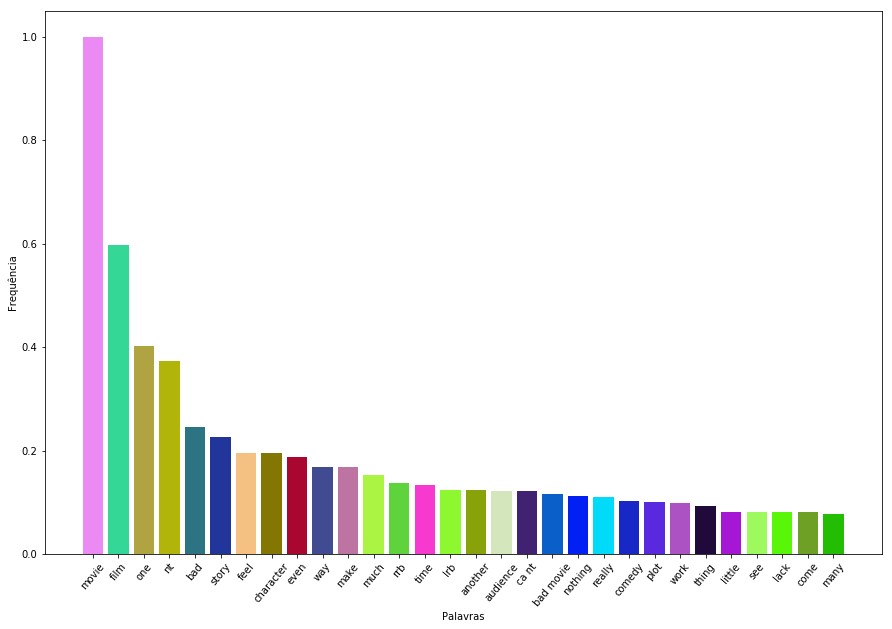

1


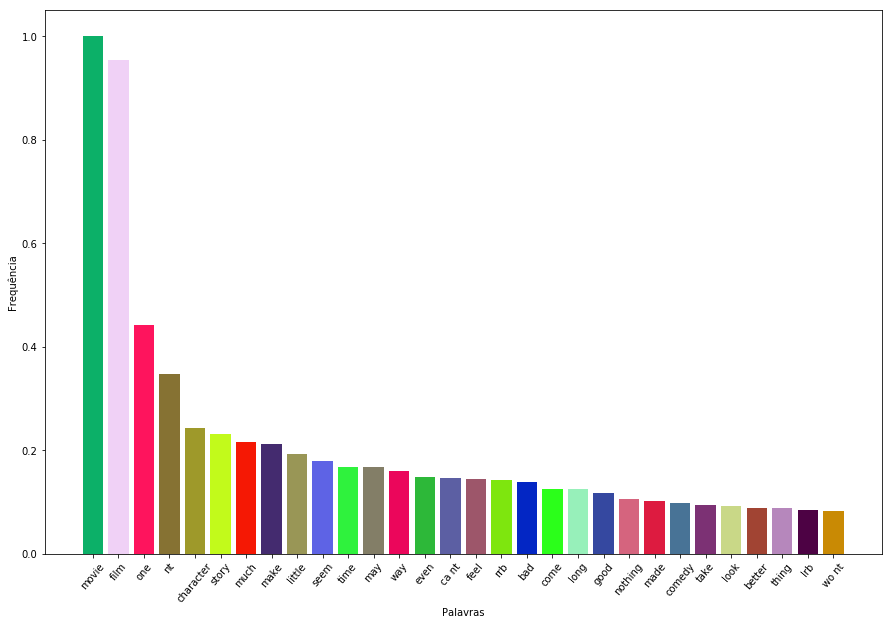

2


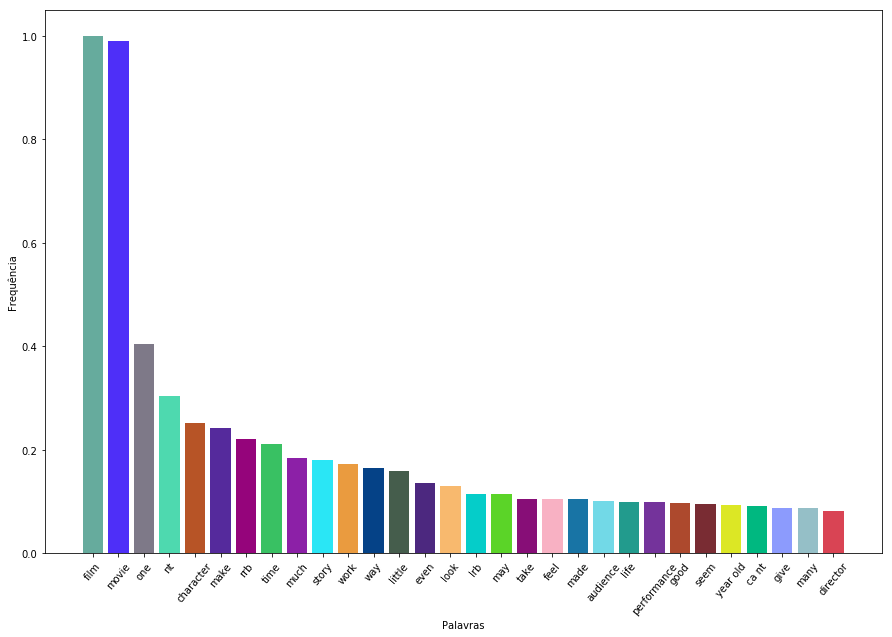

3


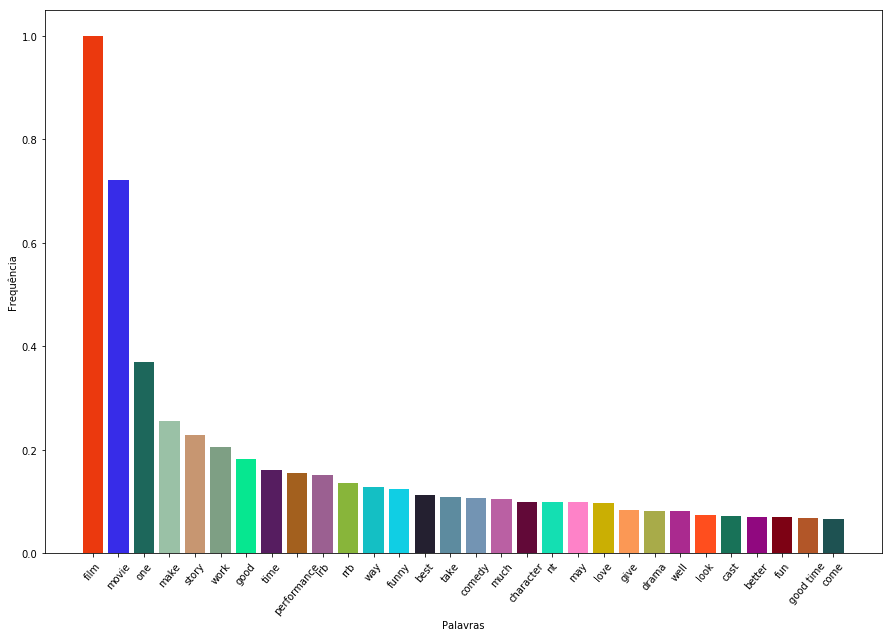

4


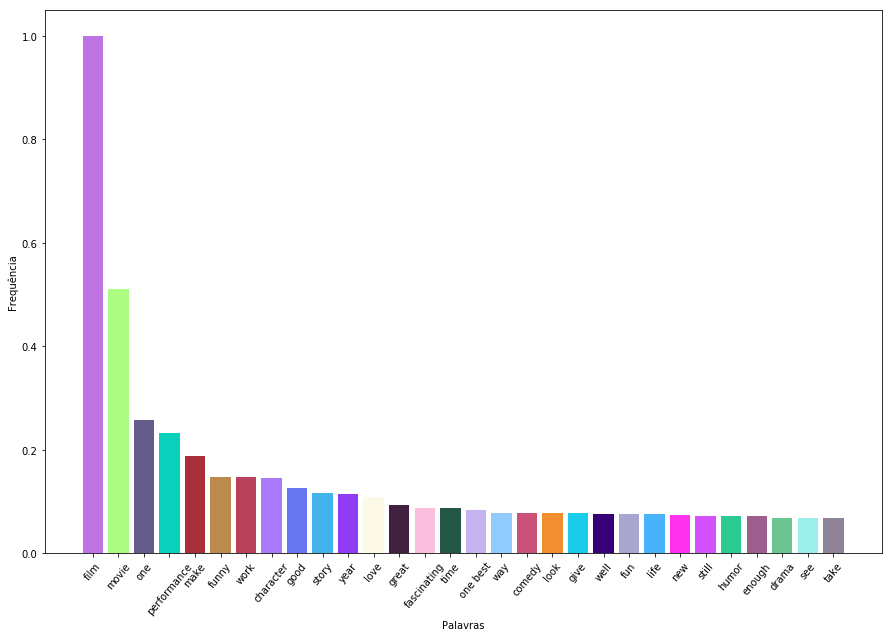

In [13]:
graficos(words)

# Gerando a saída para este primeiro dado pré-processado

In [14]:
data.to_csv("Outputs/data1.csv")

# A segunda parte se trata levar em consideração a coluna IdSentenca

In [15]:
data1 = pd.read_csv("dados/train.tsv", sep="\t")

In [16]:
new_text = []
sentimentos = []

for sentenca in data1.IdSentenca.unique():
    s = data1[data1['IdSentenca'].values == sentenca]
    ids = s["Texto"].values
    texto = " ".join(str(x) for x in ids)
    new_text.append(texto)
    sentimentos.append(s.Sentimento.mode().values[0])
    del(s)
    

In [17]:
newDataFrame = pd.DataFrame()
newDataFrame["Texto"] = new_text
newDataFrame["Sentimento"] = sentimentos

In [18]:
newDataFrame.head(10)

,Texto,Sentimento
0,A series of escapades demonstrating the adage ...,2
1,"This quiet , introspective and entertaining in...",2
2,"Even fans of Ismail Merchant 's work , I suspe...",2
3,A positively thrilling combination of ethnogra...,2
4,Aggressive self-glorification and a manipulati...,1
5,A comedy-drama of nearly epic proportions root...,2
6,"Narratively , Trouble Every Day is a plodding ...",1
7,"The Importance of Being Earnest , so thick wit...",2
8,But it does n't leave you with much . it does ...,1
9,You could hate it for the same reason . could ...,2


# Texto sem processamento

In [19]:
newDataFrame.iloc[0].Texto

'A series of escapades demonstrating the adage that what is good for the goose is also good for the gander , some of which occasionally amuses but none of which amounts to much of a story . A series of escapades demonstrating the adage that what is good for the goose A series A series of escapades demonstrating the adage that what is good for the goose of escapades demonstrating the adage that what is good for the goose escapades demonstrating the adage that what is good for the goose demonstrating the adage demonstrating the adage the adage that what is good for the goose that what is good for the goose what is good for the goose is good for the goose good for the goose for the goose goose is also good for the gander , some of which occasionally amuses but none of which amounts to much of a story . is also good for the gander , some of which occasionally amuses but none of which amounts to much of a story is also also good for the gander , some of which occasionally amuses but none of

# Aplicando limpeza

In [20]:
newDataFrame['Texto'] = newDataFrame['Texto'].apply(lambda x: clean_str(x))

In [21]:
newDataFrame.iloc[0].Texto

'series escapades demonstrating adage good goose also good gander occasionally amuses none amounts much story series escapades demonstrating adage good goose series series escapades demonstrating adage good goose escapades demonstrating adage good goose escapades demonstrating adage good goose demonstrating adage demonstrating adage adage good goose good goose good goose good goose good goose goose goose also good gander occasionally amuses none amounts much story also good gander occasionally amuses none amounts much story also also good gander occasionally amuses none amounts much story gander occasionally amuses none amounts much story gander occasionally amuses none amounts much story gander gander gander occasionally amuses none amounts much story occasionally amuses none amounts much story occasionally amuses none amounts much story amuses none amounts much story none amounts much story none amounts much story amounts much story amounts much story amounts much story much story mu

In [22]:
newDataFrame.shape

(8529, 2)

0


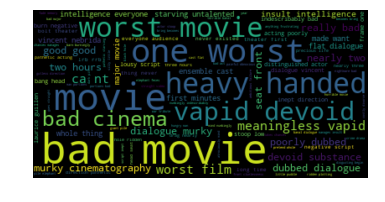

1


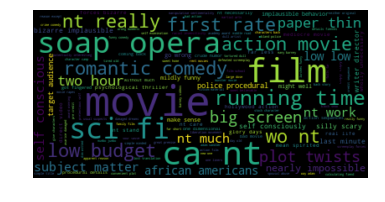

2


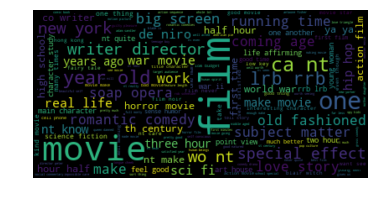

3


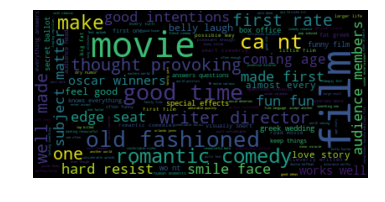

4


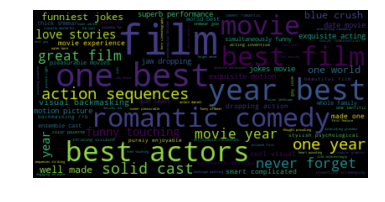

In [23]:
words = nuvem(newDataFrame)

0


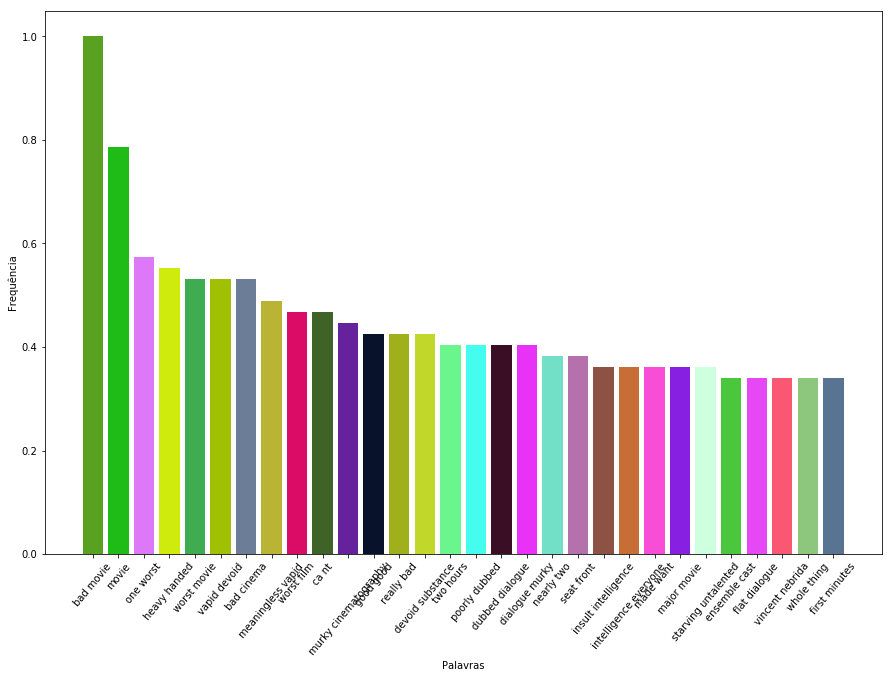

1


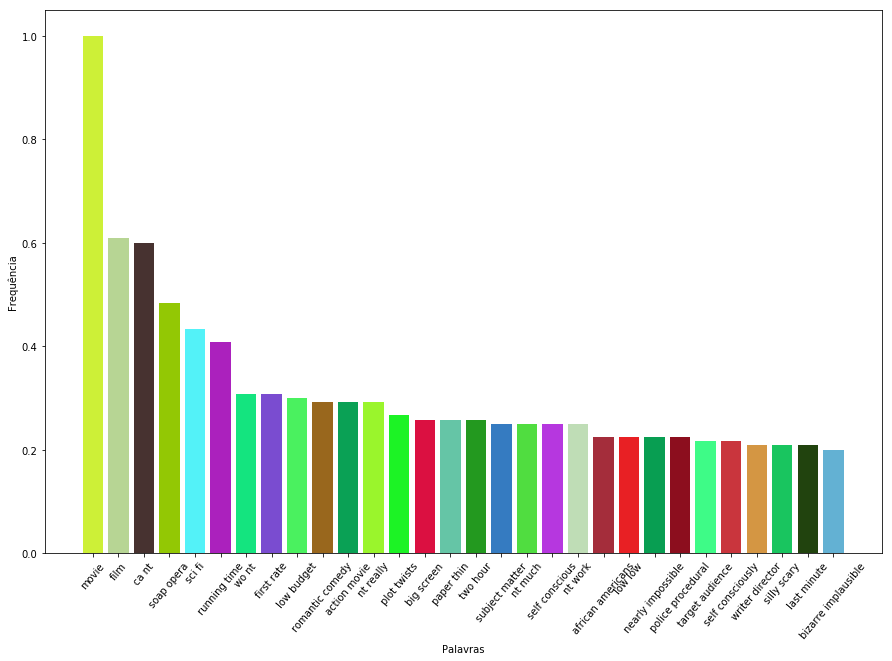

2


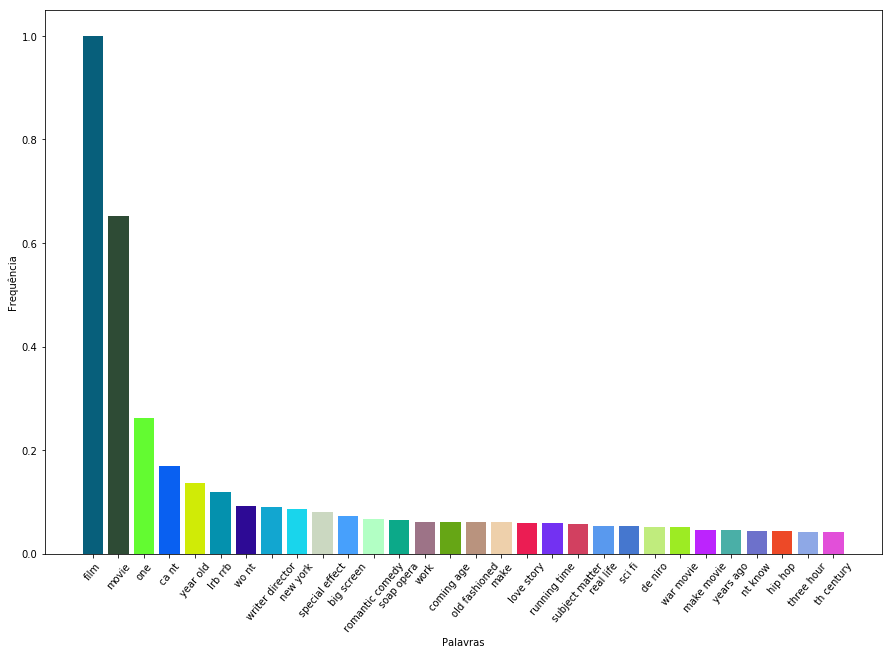

3


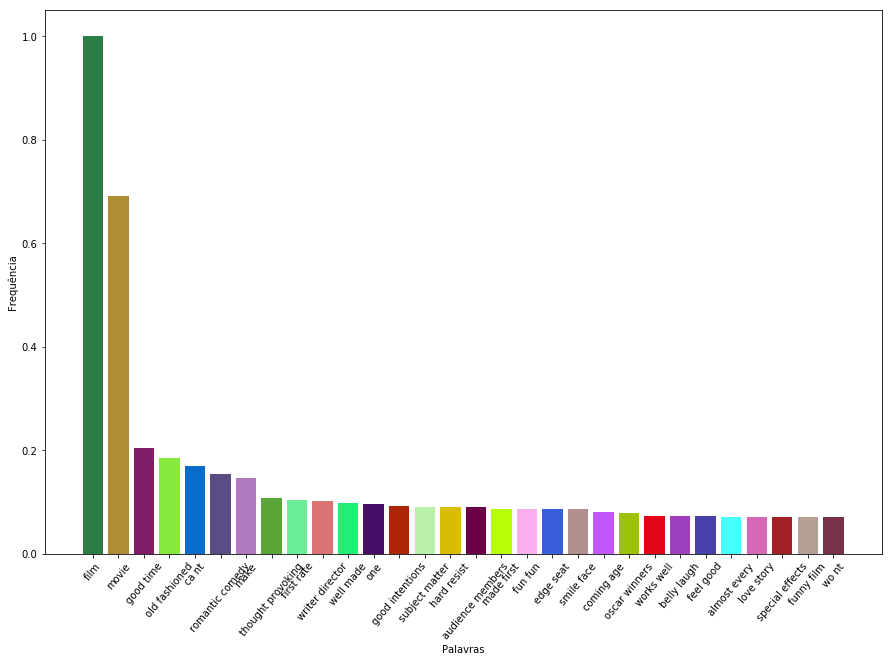

4


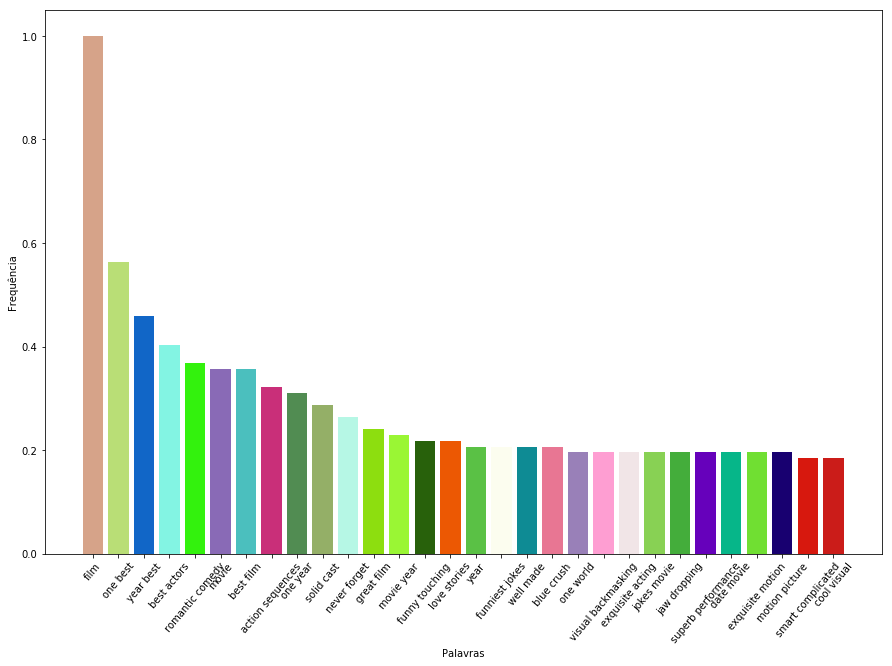

In [24]:
graficos(words)

In [25]:
data1.to_csv("Outputs/data2.csv")